In [193]:

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import matplotlib as mpl
import joblib

## Light sensors


In [194]:
ls1 = ctrl.Antecedent(np.arange(0.0, 1.01, 0.01), "ls1")
ls2 = ctrl.Antecedent(np.arange(0.0, 1.01, 0.01), "ls2")
ls3 = ctrl.Antecedent(np.arange(0.0, 1.01, 0.01), "ls3")

ls1.automf(3, names=["l", "m", "h"])
ls2.automf(3, names=["l", "m", "h"])
ls3.automf(3, names=["l", "m", "h"])

lo = ctrl.Consequent(np.arange(0, 3.01, 0.01), "lo")
lo.defuzzify_method = "mom"

lo["l"] = fuzz.trapmf(lo.universe, [0, 0, 0.5, 1])
lo["m"] = fuzz.trapmf(lo.universe, [0.5, 1, 1.5, 2])
lo["h"] = fuzz.trapmf(lo.universe, [1.5, 2, 3, 3])

In [195]:
l_rules = [
    ctrl.Rule(ls1["l"] & ls2["l"] & ~ls3["h"], lo["l"]),
    ctrl.Rule(ls1["l"] & ~ls2["h"] & ls3["l"], lo["l"]),
    ctrl.Rule(~ls1["h"] & ls2["l"] & ls3["l"], lo["l"]),
    ctrl.Rule(ls1["l"] & ~ls2["h"] & ls3["h"], lo["m"]),
    ctrl.Rule(~ls1["h"] & ls2["h"] & ls3["l"], lo["m"]),
    ctrl.Rule(ls1["h"] & ~ls2["h"] & ls3["l"], lo["m"]),
    ctrl.Rule(ls1["l"] & ls2["h"] & ls3["m"], lo["m"]),
    ctrl.Rule(ls1["m"] & ls2["l"] & ls3["h"], lo["m"]),
    ctrl.Rule(ls1["h"] & ls2["l"] & ls3["m"], lo["m"]),
    ctrl.Rule(ls1["m"] & ls2["m"] & ~ls3["h"], lo["m"]),
    ctrl.Rule(ls1["m"] & ~ls2["h"] & ls3["m"], lo["m"]),
    ctrl.Rule(~ls1["h"] & ls2["m"] & ls3["m"], lo["m"]),
    ctrl.Rule(ls1["h"] & ls2["h"], lo["h"]),
    ctrl.Rule(ls1["h"] & ls3["h"], lo["h"]),
    ctrl.Rule(ls2["h"] & ls3["h"], lo["h"]),
    ctrl.Rule(ls1["h"] & ls2["m"] & ls3["m"], lo["h"]),
    ctrl.Rule(ls1["m"] & ls2["h"] & ls3["m"], lo["h"]),
    ctrl.Rule(ls1["m"] & ls2["m"] & ls3["h"], lo["h"]),
]

lo_ctrl = ctrl.ControlSystem(l_rules)

lo_sim = ctrl.ControlSystemSimulation(lo_ctrl)


## PIR sensors


In [196]:
p1 = ctrl.Antecedent(np.arange(0.0, 1.5, 0.5), "p1")
p2 = ctrl.Antecedent(np.arange(0.0, 1.5, 0.5), "p2")

p1["no"] = fuzz.trimf(p1.universe, [0, 0, 0.5])
p1["yes"] = fuzz.trimf(p1.universe, [0.5, 1, 1])

p2["no"] = fuzz.trimf(p2.universe, [0, 0, 0.5])
p2["yes"] = fuzz.trimf(p2.universe, [0.5, 1, 1])

po = ctrl.Consequent(np.arange(0, 1.5, 0.5), "po")
po.defuzzify_method = "mom"

po["no"] = fuzz.trimf(po.universe, [0, 0, 0.5])
po["yes"] = fuzz.trimf(po.universe, [0.5, 1, 1])

In [197]:
p_rules = [
  ctrl.Rule(p1["yes"] | p2["yes"], po["yes"]),
  ctrl.Rule(p1["no"] & p2["no"], po["no"])
]

po_ctrl = ctrl.ControlSystem(p_rules)

po_sim = ctrl.ControlSystemSimulation(po_ctrl)

## Mix


In [198]:
lo_mix = ctrl.Antecedent(np.arange(0, 3.01, 0.01), "lo_mix")

lo_mix["l"] = fuzz.trapmf(lo_mix.universe, [0, 0, 0.5, 1])
lo_mix["m"] = fuzz.trapmf(lo_mix.universe, [0.5, 1, 1.5, 2])
lo_mix["h"] = fuzz.trapmf(lo_mix.universe, [1.5, 2, 3, 3])

po_mix = ctrl.Antecedent(np.arange(0, 1.5, 0.5), "po_mix")
po_mix.defuzzify_method = "mom"

po_mix["no"] = fuzz.trimf(po_mix.universe, [0, 0, 0.5])
po_mix["yes"] = fuzz.trimf(po_mix.universe, [0.5, 1, 1])

output = ctrl.Consequent(np.arange(0, 1.5, 0.5), "output")
output.defuzzify_method = "mom"

output["no"] = fuzz.trimf(output.universe, [0, 0, 0.5])
output["yes"] = fuzz.trimf(output.universe, [0.5, 1, 1])

In [199]:
output_rules = [
    ctrl.Rule(~lo_mix["h"] & po_mix["no"], output["no"]),
    ctrl.Rule(~lo_mix["h"] & po_mix["yes"], output["yes"]),
    ctrl.Rule(lo_mix["h"], output["yes"]),
]

output_ctrl = ctrl.ControlSystem(output_rules)

output_sim = ctrl.ControlSystemSimulation(output_ctrl)

In [200]:
def getOutliersFromAverage(data, gain):
    outliers = []

    for feature in data.columns:
        average = data[feature].mean()
        std = data[feature].std()

        outliers += (
            data[feature][data[feature] <= (average - std * gain)].index.tolist()
            + data[feature][data[feature] >= (average + std * gain)].index.tolist()
        )

    return list(dict.fromkeys(outliers))


def removeLine(data, indexes):
    return data.drop(indexes)


df = pd.read_csv("Proj1_Dataset.csv")

for feature in df.columns:
    df = df[df[feature].notna()]

df_features = df.drop(["Date", "Time", "Persons"], axis=1)

df_output = df["Persons"]

for feature in df_features.columns:
    if feature == "PIR1" or feature == "PIR2":
        continue

    df_features[feature] = (df_features[feature] - df_features[feature].mean()) / df_features[feature].std(ddof=0)

outliers = getOutliersFromAverage(df_features, 6)
df_features = removeLine(df_features, outliers)
df_output = removeLine(df_output, outliers)


for i, row in df_output.items(): 
    if row == 3:
        df_output[i] = 1
    else:
        df_output[i] = 0

df_features["S1Light"] = (df_features["S1Light"] - df_features["S1Light"].min()) / (df_features["S1Light"].max() - df_features["S1Light"].min())
df_features["S2Light"] = (df_features["S2Light"] - df_features["S2Light"].min()) / (df_features["S2Light"].max() - df_features["S2Light"].min())
df_features["S3Light"] = (df_features["S3Light"] - df_features["S3Light"].min()) / (df_features["S3Light"].max() - df_features["S3Light"].min())

In [201]:
X = df_features.to_numpy()
X = np.concatenate((X[:, 3:6], X[:, 7:9]), axis=1)
Y = df_output.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

Precision: 0.4525096525096525
Recall: 0.9466882067851373
F1: 0.6123301985370951


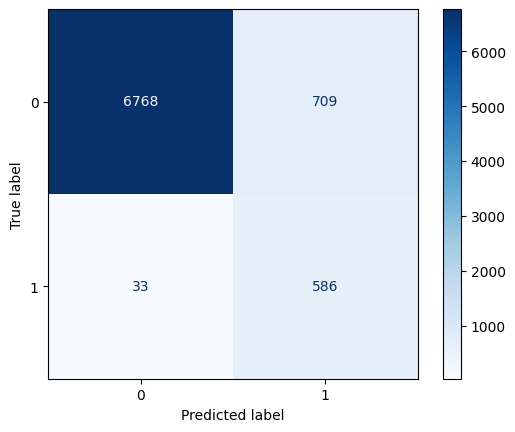

Precision: 0.4634146341463415
Recall: 0.9382716049382716
F1: 0.6204081632653061


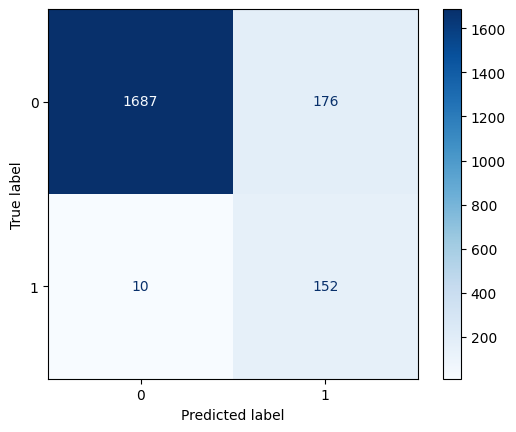

In [202]:
TP = TN = FP = FN = 0

y_pred = []

# train
for id, x in enumerate(X_train):
    # compute total light
    lo_sim.input["ls1"] = x[0]
    lo_sim.input["ls2"] = x[1]
    lo_sim.input["ls3"] = x[2]

    lo_sim.compute()
    lo_mix_in = lo_sim.output["lo"]

    # compute total motion
    po_sim.input["p1"] = x[3]
    po_sim.input["p2"] = x[4]

    po_sim.compute()
    po_mix_in = po_sim.output["po"]

    # compute mix
    output_sim.input["lo_mix"] = lo_mix_in
    output_sim.input["po_mix"] = po_mix_in

    output_sim.compute()

    correct = y_train[id]
    predicted = 0 if output_sim.output["output"] < 0.5 else 1
    
    y_pred.append(predicted)

    if predicted == 1 and correct == 1:
        TP += 1
    elif predicted == 0 and correct == 0:
        TN += 1
    elif predicted == 1 and correct == 0:
        FP += 1
    elif predicted == 0 and correct == 1:
        FN += 1

print(f"Precision: {TP/(TP+FP)}")
print(f"Recall: {TP/(TP+FN)}")
print(f"F1: {2*TP/(2*TP+FP+FN)}")

ConfusionMatrixDisplay.from_predictions(y_train, y_pred, cmap=mpl.cm.Blues)
plt.show()

TP = TN = FP = FN = 0

y_pred = []

# test
for id, x in enumerate(X_test):
    # compute total light
    lo_sim.input["ls1"] = x[0]
    lo_sim.input["ls2"] = x[1]
    lo_sim.input["ls3"] = x[2]

    lo_sim.compute()
    lo_mix_in = lo_sim.output["lo"]

    # compute total motion
    po_sim.input["p1"] = x[3]
    po_sim.input["p2"] = x[4]

    po_sim.compute()
    po_mix_in = po_sim.output["po"]

    # compute mix
    output_sim.input["lo_mix"] = lo_mix_in
    output_sim.input["po_mix"] = po_mix_in

    output_sim.compute()

    correct = y_test[id]
    predicted = 0 if output_sim.output["output"] < 0.5 else 1

    y_pred.append(predicted)

    if predicted == 1 and correct == 1:
        TP += 1
    elif predicted == 0 and correct == 0:
        TN += 1
    elif predicted == 1 and correct == 0:
        FP += 1
    elif predicted == 0 and correct == 1:
        FN += 1


print(f"Precision: {TP/(TP+FP)}")
print(f"Recall: {TP/(TP+FN)}")
print(f"F1: {2*TP/(2*TP+FP+FN)}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=mpl.cm.Blues)
plt.show()


Precision: 0.896969696969697
Recall: 0.9135802469135802
F1: 0.9051987767584098


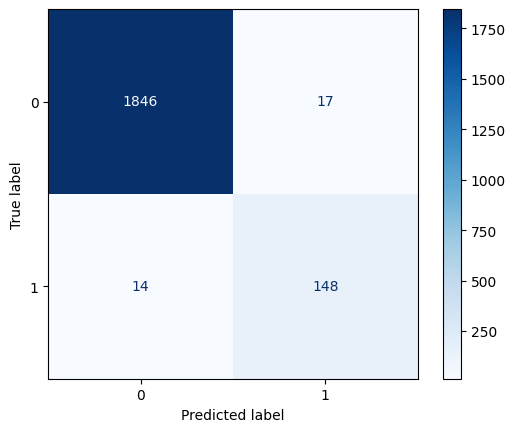

In [203]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i] == y_hat[i] == 1:
            TP += 1
        if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
            FP += 1
        if y_actual[i] == y_hat[i] == 0:
            TN += 1
        if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
            FN += 1

    return (TP, FP, TN, FN)

# MLP to compare
clf = MLPClassifier(random_state=0, max_iter=200)

y_pred = clf.fit(X_train, y_train).predict(X_test)

TP, FP, TN, FN = perf_measure(y_test, y_pred)

print(f"Precision: {TP/(TP+FP)}")
print(f"Recall: {TP/(TP+FN)}")
print(f"F1: {2*TP/(2*TP+FP+FN)}")

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=mpl.cm.Blues)
plt.show()


In [204]:
joblib.dump(clf, 'trained_mlp_fuzzy.sav')
joblib.dump(lo_sim, 'lo_sim.sav')
joblib.dump(po_sim, 'po_sim.sav')
joblib.dump(output_sim, 'output_sim.sav')

['output_sim.sav']

Precision: 0.4634146341463415
Recall: 0.9382716049382716
F1: 0.6204081632653061


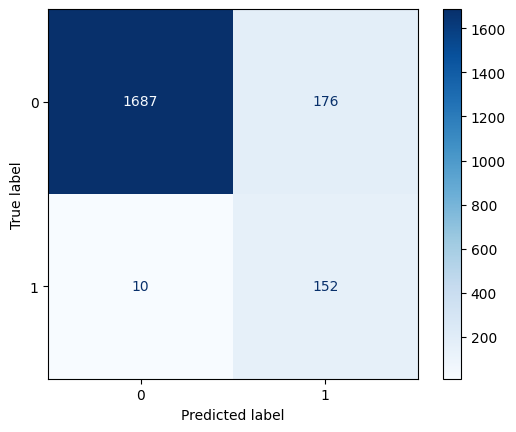

Precision: 0.896969696969697
Recall: 0.9135802469135802
F1: 0.9051987767584098


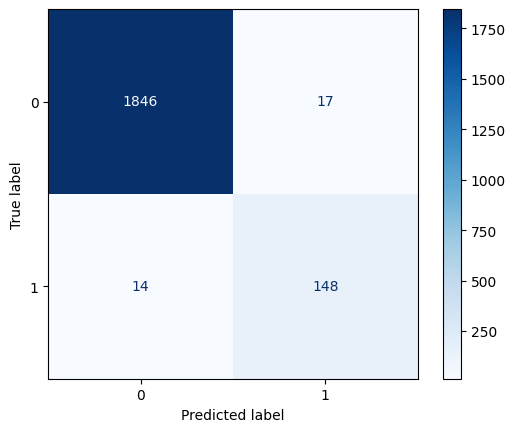

In [205]:
clf = joblib.load("trained_mlp_fuzzy.sav")
lo_sim = joblib.load("lo_sim.sav")
po_sim = joblib.load("po_sim.sav")
output_sim = joblib.load("output_sim.sav")

TP = TN = FP = FN = 0

y_pred = []

# test
for id, x in enumerate(X_test):
    # compute total light
    lo_sim.input["ls1"] = x[0]
    lo_sim.input["ls2"] = x[1]
    lo_sim.input["ls3"] = x[2]

    lo_sim.compute()
    lo_mix_in = lo_sim.output["lo"]

    # compute total motion
    po_sim.input["p1"] = x[3]
    po_sim.input["p2"] = x[4]

    po_sim.compute()
    po_mix_in = po_sim.output["po"]

    # compute mix
    output_sim.input["lo_mix"] = lo_mix_in
    output_sim.input["po_mix"] = po_mix_in

    output_sim.compute()

    correct = y_test[id]
    predicted = 0 if output_sim.output["output"] < 0.5 else 1

    y_pred.append(predicted)

    if predicted == 1 and correct == 1:
        TP += 1
    elif predicted == 0 and correct == 0:
        TN += 1
    elif predicted == 1 and correct == 0:
        FP += 1
    elif predicted == 0 and correct == 1:
        FN += 1


print(f"Precision: {TP/(TP+FP)}")
print(f"Recall: {TP/(TP+FN)}")
print(f"F1: {2*TP/(2*TP+FP+FN)}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=mpl.cm.Blues)
plt.show()

# MLP to compare

y_pred = clf.predict(X_test)

TP, FP, TN, FN = perf_measure(y_test, y_pred)

print(f"Precision: {TP/(TP+FP)}")
print(f"Recall: {TP/(TP+FN)}")
print(f"F1: {2*TP/(2*TP+FP+FN)}")

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=mpl.cm.Blues)
plt.show()